# DeepFreq v.s. Other Frequency Representation Methods

In [57]:
import os
import numpy as np
import torch
import util
import matplotlib.pyplot as plt
import cvxpy as cp

from numpy import fft
from scipy.linalg import dft, hankel, svd, norm, pinv
from data import fr

%matplotlib inline

In [58]:
''' Create Harmonic Signal (On-grid) '''
def snr(signal, noise):
    return 20 * np.log10(norm(signal) / norm(noise))

# Signal parameters
N = 1000
M = 50

# Noise parameters
sig = 0.0
n = np.zeros((M, 1), dtype=complex)
n.real = sig * np.random.randn(M, 1)
n.imag = sig * np.random.randn(M, 1)


# Signal (in frequency)
x = np.zeros([N, 1])

# Sensor and frequncy grids
spos = np.arange(M).reshape(-1, 1)
fgrid = fft.fftfreq(N).reshape(-1, 1)

# Measurement matrix
A = np.exp(1j * 2*np.pi * spos @ fgrid.T)   # normalization 1/M will be be included later

# signal amplitudes and angles
c = np.asarray([1.0, 1.0]).reshape(-1, 1)
th_ind = np.asarray([10, 100])
#th_ind = np.random.choice(np.arange(N), size=3)

th = fgrid[th_ind]
x[th_ind] = c

# Create time-domain measurements
''' By using the A matrix, to create these sinusoids, I am enforcing frequencies to exist on the grid. '''
y = A @ x + n

print("snr(x,n) = {}".format(snr(x,n)))

snr(x,n) = inf


/home/jake/mambaforge/envs/torch-v1.1.0/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


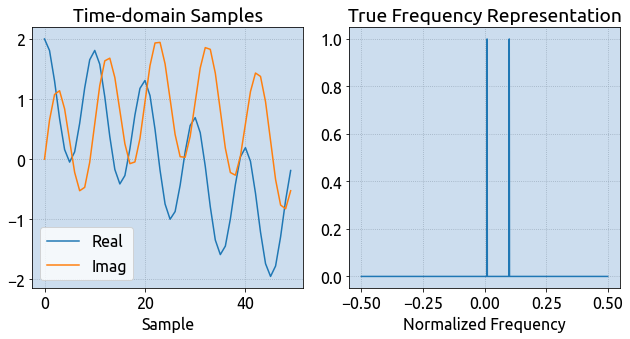

In [22]:
''' Plot Signal '''
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Ubuntu"
fig, ax = plt.subplots(1, 2, figsize=(9, 5))

ax[0].plot(y.real, label='Real')
ax[0].plot(y.imag, label='Imag')
ax[0].set_title("Time-domain Samples")
ax[0].set_xlabel("Sample")
ax[0].set_facecolor("#CCDDEE")
ax[0].grid(color='#99AABB', linestyle=':')
ax[0].legend()

ax[1].plot(fft.fftshift(fgrid), fft.fftshift(x))
ax[1].set_title("True Frequency Representation")
ax[1].set_xlabel("Normalized Frequency")
ax[1].set_facecolor("#CCDDEE")
ax[1].grid(color='#99AABB', linestyle=':')

plt.tight_layout()
plt.show()

In [23]:
''' Process DeepFreq Network ''' 
y_df = np.stack([y.real, y.imag], axis=0).astype(np.float32)
y_df = np.moveaxis(y_df, -1, 0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model paths
fr_path = 'pretrained_models/DeepFreq/frequency_representation_module.pth'
fc_path = 'pretrained_models/DeepFreq/frequency_counting_module.pth'
data_dir = 'jake_dataset'

# Load models
fr_module, _, _, _, _ = util.load(fr_path, 'fr', device)
fc_module, _, _, _, _ = util.load(fc_path, 'fc', device)
fr_module.cpu()
fr_module.eval()
fc_module.cpu()
fc_module.eval()

print(y_df.shape)

(1, 2, 50)


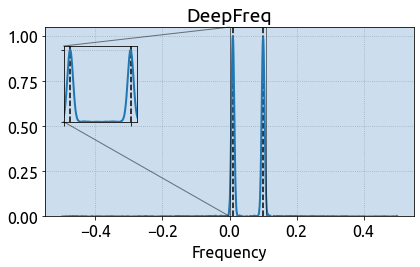

In [24]:
''' DeepFreq Representation '''
# Process signal with network
with torch.no_grad():
    S_df = fr_module(torch.tensor(y_df))
S_df = S_df.numpy()

# Plot
zoom_space = 0.01
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(fft.fftshift(fgrid), S_df[0], linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
ax.vlines(th, linestyle='--', ymin=0, ymax=y2, color='k', label='True frequency')
ax.set_ylim(0, y2)
ax.set_xlabel('Frequency')
ax.set_title('DeepFreq')
ax.grid(color='#99AABB', linestyle=':')
ax.set_facecolor('#CCDDEE')

# Zoomed plot
axins = ax.inset_axes([0.05, 0.5, 0.2, 0.4])
axins.plot(fft.fftshift(fgrid), S_df[0], linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
axins.vlines(th, linestyle='--', ymin=y1, ymax=y2, color='k', label='True frequency')
x1, x2 = th.min()-zoom_space, th.max()+zoom_space
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.grid(color='#99AABB', linestyle=':')
axins.set_facecolor('#CCDDEE')

ax.indicate_inset_zoom(axins, edgecolor="k")

plt.tight_layout()
plt.show()

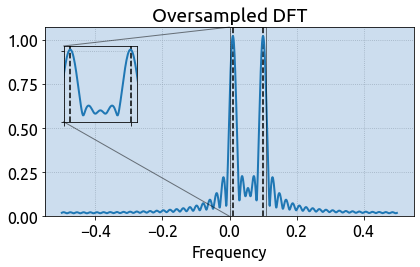

In [25]:
''' Oversampled FFT, i.e. Minimum L2-norm Solution '''
# Use pseudo-inverse of iFFT, i.e. FFT
S_l2 = np.abs(1/M * A.conj().T @ y)

# Plot
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(fft.fftshift(fgrid), fft.fftshift(S_l2), linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
ax.vlines(th, linestyle='--', ymin=0, ymax=y2, color='k', label='True frequency')
ax.set_ylim(0, y2)
ax.set_xlabel('Frequency')
ax.set_title('Oversampled DFT')
ax.grid(color='#99AABB', linestyle=':')
ax.set_facecolor('#CCDDEE')

# Zoomed plot
axins = ax.inset_axes([0.05, 0.5, 0.2, 0.4])
axins.plot(fft.fftshift(fgrid), fft.fftshift(S_l2), linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
axins.vlines(th, linestyle='--', ymin=y1, ymax=y2, color='k', label='True frequency')
x1, x2 = th.min()-zoom_space, th.max()+zoom_space
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.grid(color='#99AABB', linestyle=':')
axins.set_facecolor('#CCDDEE')

ax.indicate_inset_zoom(axins, edgecolor="k")

plt.tight_layout()
plt.show()

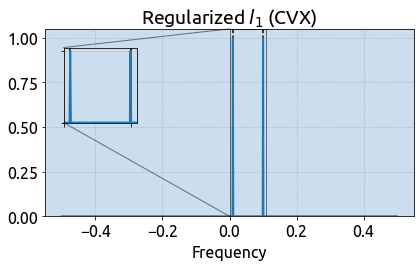

In [26]:
''' Minimum L1 Norm Solution '''

x = cp.Variable(N)
cost = cp.norm(x, 1)
constraint = [cp.norm(A @ x - y.flatten(), 2) <= 2*sig]
#constraint = [A @ x == y[:,0]]
prob = cp.Problem(cp.Minimize(cost), constraint)
prob.solve()
S_l1 = np.abs(x.value)

# Plot
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(fft.fftshift(fgrid), fft.fftshift(S_l1), linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
ax.vlines(th, linestyle='--', ymin=0, ymax=y2, color='k', label='True frequency')
ax.set_ylim(0, y2)
ax.set_xlabel('Frequency')
ax.set_title('Regularized $l_1$ (CVX)')
ax.grid(color='#99AABB', linestyle=':')
ax.set_facecolor('#CCDDEE')

# Zoomed plot
axins = ax.inset_axes([0.05, 0.5, 0.2, 0.4])
axins.plot(fft.fftshift(fgrid), fft.fftshift(S_l1), linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
axins.vlines(th, linestyle='--', ymin=y1, ymax=y2, color='k', label='True frequency')
x1, x2 = th.min()-zoom_space, th.max()+zoom_space
axins.set_xlim(x1, x2)
axins.set_ylim(0, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.grid(color='#99AABB', linestyle=':')
axins.set_facecolor('#CCDDEE')

ax.indicate_inset_zoom(axins, edgecolor="k")

plt.tight_layout()
plt.show()

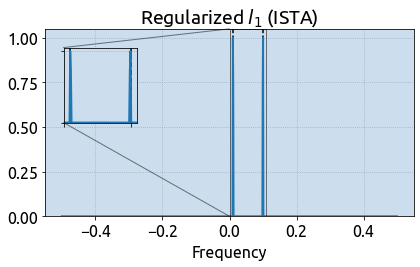

In [27]:
''' Solving l1 by ISTA '''
import numpy as np
from scipy.linalg import norm

def relu(x):
    return x * (x > 0)
def soft_threshold(x, t):
    return np.sign(x) * relu(np.abs(x) - t)
def ista(A, b, l=1, maxit=50):
    M, N = A.shape
    #x = np.zeros([N, 1])
    # initialize with pseudo-inverse solution
    x = pinv(A) @ b
    L = norm(A) ** 2
    AHA = A.conj().T @ A
    AH = A.conj().T
    for _ in range(maxit):
        x = soft_threshold(x - (1/L * AHA @ x) + (1/L * AH @ b) , l / L)
    return x
    
l = 50
maxit = 600
S_ista = np.abs(ista(A, y, l, maxit)) 
S_ista /= S_ista.max()

# Plot
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(fft.fftshift(fgrid), fft.fftshift(S_ista), linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
ax.vlines(th, linestyle='--', ymin=0, ymax=y2, color='k', label='True frequency')
ax.set_ylim(0, y2)
ax.set_xlabel('Frequency')
ax.set_title('Regularized $l_1$ (ISTA)')
ax.grid(color='#99AABB', linestyle=':')
ax.set_facecolor('#CCDDEE')

# Zoomed plot
axins = ax.inset_axes([0.05, 0.5, 0.2, 0.4])
axins.plot(fft.fftshift(fgrid), fft.fftshift(S_ista), linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
axins.vlines(th, linestyle='--', ymin=y1, ymax=y2, color='k', label='True frequency')
x1, x2 = th.min()-zoom_space, th.max()+zoom_space
axins.set_xlim(x1, x2)
axins.set_ylim(0, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.grid(color='#99AABB', linestyle=':')
axins.set_facecolor('#CCDDEE')

ax.indicate_inset_zoom(axins, edgecolor="k")

plt.tight_layout()
plt.show()

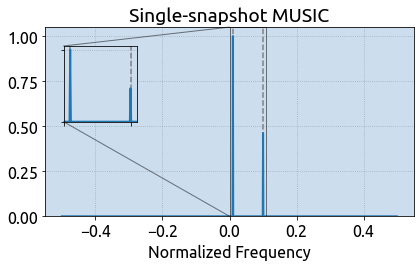

In [28]:
''' Single Snapshot MUSIC '''
L = M//2
Hkl = hankel(y[:L+1], y[L:])
U, s, _ = svd(Hkl, full_matrices=True)
U2 = U[:, len(th):] # must know source number
projection = norm(U2.conj().T @ A[:L+1, :], axis=0)
S_ssm = 1/projection
S_ssm /= S_ssm.max()

# Plot
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(fft.fftshift(fgrid), fft.fftshift(S_ssm), linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
ax.vlines(th, linestyle='--', ymin=y1, ymax=y2, color='gray', label='True frequency')
ax.set_ylim(0, y2)
ax.set_xlabel('Normalized Frequency')
ax.set_title('Single-snapshot MUSIC')
ax.grid(color='#99AABB', linestyle=':')
ax.set_facecolor('#CCDDEE')

# Zoomed plot
axins = ax.inset_axes([0.05, 0.5, 0.2, 0.4])
axins.plot(fft.fftshift(fgrid), fft.fftshift(S_ssm), linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
axins.vlines(th, linestyle='--', ymin=y1, ymax=y2, color='gray', label='True frequency')
x1, x2 = th.min()-zoom_space, th.max()+zoom_space
axins.set_xlim(x1, x2)
axins.set_ylim(0, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.grid(color='#99AABB', linestyle=':')
axins.set_facecolor('#CCDDEE')

ax.indicate_inset_zoom(axins, edgecolor="k")

plt.tight_layout()
plt.show()

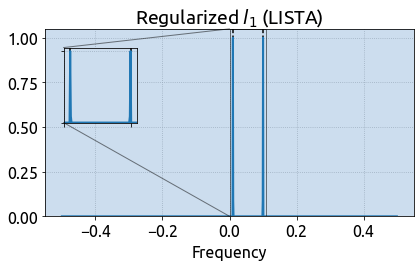

In [29]:
''' Solve with LISTA '''
def Aop(A, x):
    # Aop - Forward model process
    # args in -
    #   A - measurement matrix
    #   x - input vector
    return torch.matmul(A,x)

def softthr(x, thr):
    # softthr - Soft thresholding operator
    # args in -
    #   x - input vector
    #   thr - shrinkage threshold
    # args out - 
    #   z - output vector
    z = torch.abs(x) - thr
    z = z * torch.sign(x) * (torch.abs(x) > thr).type(x.dtype) 
    return z

def pbnet(A, alpha, lamb, x0, y_meas, K, testFlag=True):

    x = x0.detach().clone()
    x.requires_grad = True
    
    AHA = torch.matmul(torch.transpose(A, 0, 1), A)
    AHy = torch.matmul(torch.transpose(A, 0, 1), y_meas)

    if testFlag: y_meas = y_meas.detach()
            
    for kk in range(K):
        y_est = Aop(A,x)
        g = torch.matmul(AHA, x) - AHy
        
        x = x - alpha*g           # gradient update
        x = softthr(x, lamb*alpha)   # proximal update
        
    return x

# Need to represent complex numbers as matrix
A_repr = np.block([
    [A.real, -A.imag],
    [A.imag, A.real]
])
y_repr = np.block([
    [y.real, -y.imag],
    [y.imag, y.real]
])

# process for network
A_torch = torch.from_numpy(A_repr)
y_torch = torch.from_numpy(y_repr)
x_init = torch.from_numpy( pinv(A_repr) @ y_repr)
x0 = x_init.detach().clone()
emax = np.max(abs(np.linalg.eig(A.T @ A)[0]))

max_iter = 600
alpha = 1
thr = 40

alpha /= emax

# evaluate lista
x_lista = pbnet(A_torch.to('cpu'), alpha, thr, x0.to('cpu'), y_torch.to('cpu'), max_iter, testFlag=True).detach().cpu().numpy()

# Convert back to complex form
S_lista = np.zeros(N, dtype=complex)
S_lista.real = x_lista[:N, 0]
S_lista.imag = x_lista[N:, 0]
S_lista = np.abs(S_lista)
S_lista = S_lista / S_lista.max()

# Plot
zoom_space = 0.01
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(fft.fftshift(fgrid), fft.fftshift(S_lista), linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
ax.vlines(th, linestyle='--', ymin=0, ymax=y2, color='k', label='True frequency')
ax.set_ylim(0, y2)
ax.set_xlabel('Frequency')
ax.set_title('Regularized $l_1$ (LISTA)')
ax.grid(color='#99AABB', linestyle=':')
ax.set_facecolor('#CCDDEE')

# Zoomed plot
axins = ax.inset_axes([0.05, 0.5, 0.2, 0.4])
axins.plot(fft.fftshift(fgrid), fft.fftshift(S_lista), linewidth=2, label='Frequency representation')
y1, y2 = ax.get_ylim()
axins.vlines(th, linestyle='--', ymin=y1, ymax=y2, color='k', label='True frequency')
x1, x2 = th.min()-zoom_space, th.max()+zoom_space
axins.set_xlim(x1, x2)
axins.set_ylim(0, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.grid(color='#99AABB', linestyle=':')
axins.set_facecolor('#CCDDEE')

ax.indicate_inset_zoom(axins, edgecolor="k")

plt.tight_layout()
plt.show()

(2, 1)
(50, 1)
(26, 25)


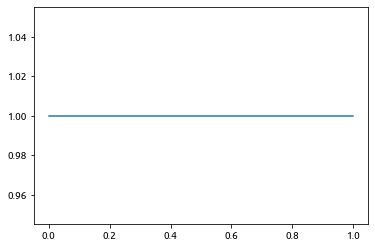

In [88]:
''' Iterative MUSIC '''
from scipy.signal import find_peaks

def buildManifold(flist, M):
    A = np.zeros([M, len(flist)], dtype=complex)
    for i, freq in enumerate(flist):
        A[:, i] = np.exp(1j* 2*np.pi* freq * np.arange(M))
    return A

L = M//2
Hkl = hankel(y[:L+1], y[L:])
U, s, _ = svd(Hkl, full_matrices=True)
U2 = U[:, len(th):] # must know source number
projection = norm(U2.conj().T @ A[:L+1, :], axis=0)
S_im = 1/projection
S_im /= S_im.max()


R_0 = Hkl @ Hkl.conj().T
for l in range(1):
    findx, _ = find_peaks(S_im, height=0.2)
    A_l = buildManifold(fgrid[findx], M)
    s_l = pinv(A_l) @ y
    n_l = y - A_l @ s_l
    
    print(s_l.shape)
    print(n_l.shape)
    print(Hkl.shape)
    
    R_l = A_l @ s_l @ n_l.conj().T
    
    
plt.plot(s_l.real)
#plt.plot(y.real)

In [ ]:
''' SPICE '''